In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc
import numpy as np

In [2]:
n_x = 500
mesh = df.Mesh(p1=(-50e-9, 0, 0), p2=( 50e-9, 1e-9, 1e-9), n=(n_x, 1, 1))

In [3]:
# Material parameters
A = 13e-12  # Jm^-1
D = 3e-3    # Jm^-2
M_s = 8.6e5 # Am^-1
K_u = 4e5   # Jm^-3

In [4]:
system = mm.System(name="chain")

In [5]:
system.m = df.Field(mesh, nvdim=3, value=[0, 0, 1], norm=M_s)

In [6]:
system.energy = mm.Exchange(A=A) + mm.DMI(D=D, crystalclass="Cnv_z") + mm.UniaxialAnisotropy(K=K_u, u=[0, 0, 1])

In [7]:
mindriver = oc.MinDriver()

In [8]:
mindriver.drive(system)

Running OOMMF (ExeOOMMFRunner)[2023/11/24 17:34]... (0.4 s)


In [9]:
mx = np.squeeze(system.m.orientation.array[..., 0])
mz = np.squeeze(system.m.orientation.array[..., 2])

## Importing simulation results from mumax3

In [10]:
mumax_m = df.Field.from_file(f"mumax3-files/m_interface_{n_x}_mumax3_periodic_y.ovf")

In [11]:
mumax_mx = np.squeeze(mumax_m.orientation.array[..., 0])
mumax_mz = np.squeeze(mumax_m.orientation.array[..., 2])

## Shooting method

The equation to be sloved:
$
$

In [12]:
import scipy
# Use units in the nm scale
nm = 1e-9
delta = (np.sqrt(A / K_u)) / nm
xi = (2 * A / D) / nm

# Set of differential equations for (u, v)
def ode_1d(theta, r, delta=1):
    return np.array([theta[1], 
                      np.cos(theta[0]) * np.sin(theta[0]) / delta ** 2
                      ])


# Define a function to solve the differential equation in the (0, l) range
# for any v(0) condition, u(0) is set to 1/xi
# The function returns the difference with respect to the desired solution at x=l
# The boundary conditions differ in sign for the interfacial and DMI cases
r_array = np.array([system.m.mesh.region.pmin[0]] + list(system.m.mesh.points.x) + [system.m.mesh.region.pmax[0]]) / nm

def solve_ode(a, sign=1):  
    # Impose the condition over the angle rather than its derivative
    solution, info = scipy.integrate.odeint(lambda t, r: ode_1d(t, r, delta=delta), 
                                            [np.arcsin(sign * delta / xi), a], r_array, full_output=True)
    # By inspection we found that the right extrema must be positive to match
    # the condition for the derivative
    return solution[:, 0][-1] - np.arcsin(-sign * delta / xi)

In [13]:
guess_bulk = scipy.optimize.brentq(lambda a: solve_ode(a, sign=-1), 0.2, 0.)
print('Bulk: ', guess_bulk)

Bulk:  0.11538462908280177


In [14]:
solution_interface, info = scipy.integrate.odeint(lambda t, r: ode_1d(t, r, delta=delta), 
                                             [np.arcsin(- delta / xi), guess_bulk], r_array, full_output=True)

In [15]:
solution_interface.shape

(502, 2)

## Comparing the results

In [16]:
import matplotlib.pyplot as plt

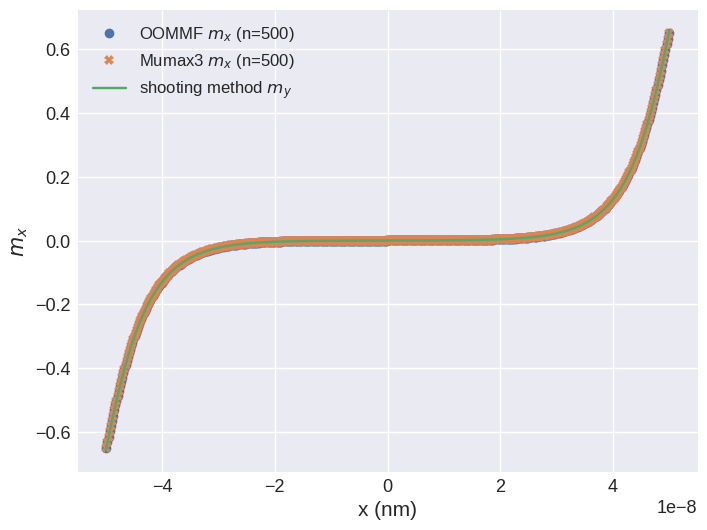

In [17]:
plt.plot(system.m.mesh.points.x, mx, 'o', label=f"OOMMF $m_x$ (n={n_x})")
plt.plot(system.m.mesh.points.x, mumax_mx, 'X', label=f"Mumax3 $m_x$ (n={n_x})")
plt.plot((r_array)*nm, np.sin(solution_interface[:, 0]), label="shooting method $m_y$")

plt.legend()
plt.grid(True)
plt.xlabel("x (nm)")
plt.ylabel("$m_x$")
plt.show()

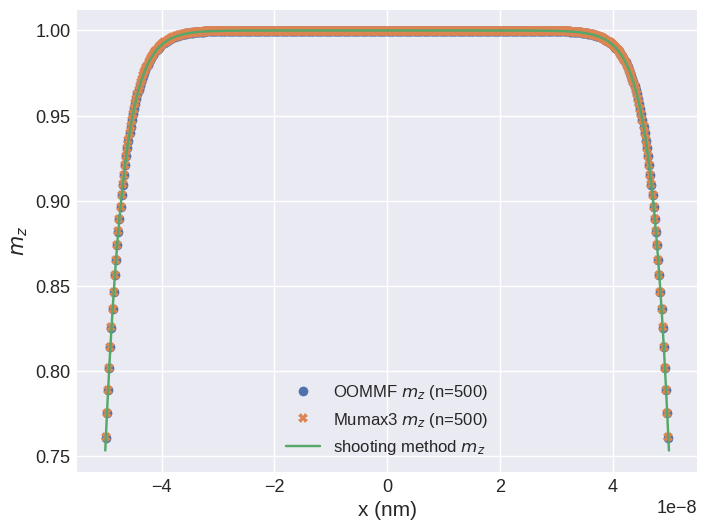

In [18]:
plt.plot(system.m.mesh.points.x, mz, 'o', label=f"OOMMF $m_z$ (n={n_x})")
plt.plot(system.m.mesh.points.x, mumax_mz, 'X', label=f"Mumax3 $m_z$ (n={n_x})")
plt.plot((r_array)*nm, np.cos(solution_interface[:, 0]), label="shooting method $m_z$")

plt.legend()
plt.grid(True)
plt.xlabel("x (nm)")
plt.ylabel("$m_z$")
plt.show()

## Difference compared to shooting method

In [19]:
my_oommf = np.sin(solution_interface[1:-1, 0]) - mx
my_mumax = np.sin(solution_interface[1:-1, 0]) - mumax_mx

In [20]:
mz_oommf = np.cos(solution_interface[1:-1, 0]) - mz
mz_mumax = np.cos(solution_interface[1:-1, 0]) - mumax_mz

<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_10780/611111830.py:7: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta m_x$")


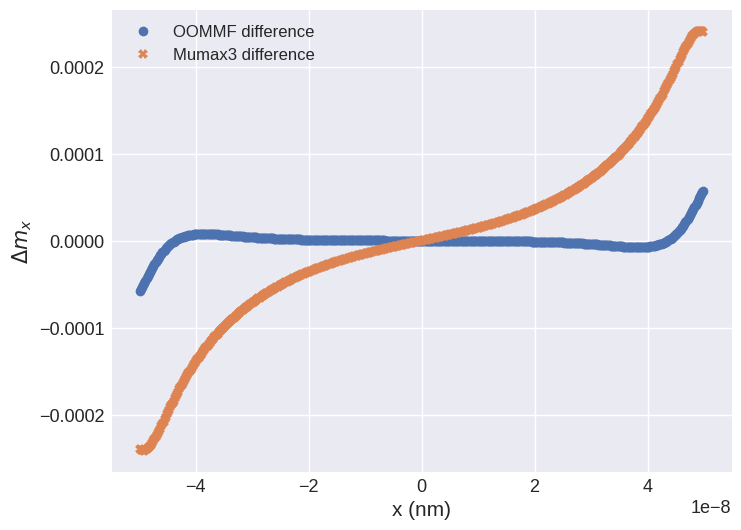

In [21]:
plt.plot(system.m.mesh.points.x, my_oommf, "o", label="OOMMF difference")
plt.plot(system.m.mesh.points.x, my_mumax, "X", label="Mumax3 difference")

plt.legend()
plt.grid(True)
plt.xlabel("x (nm)")
plt.ylabel("$\Delta m_x$")
plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_10780/1065771301.py:7: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta m_z$")


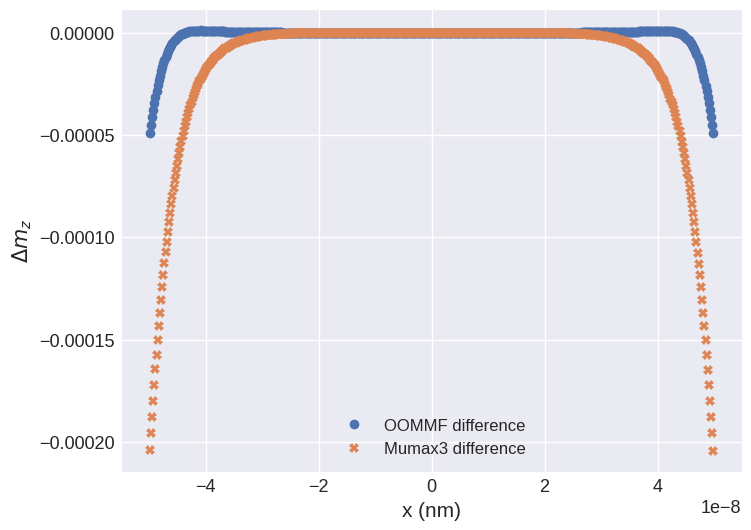

In [22]:
plt.plot(system.m.mesh.points.x, mz_oommf, "o", label="OOMMF difference")
plt.plot(system.m.mesh.points.x, mz_mumax, "X", label="Mumax3 difference")

plt.legend()
plt.grid(True)
plt.xlabel("x (nm)")
plt.ylabel("$\Delta m_z$")
plt.show()